In [1]:
!pip install datasets

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel")

Skipping, found downloaded files in "./retina-blood-vessel" (use force=True to force download)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Visualizing sample 1:


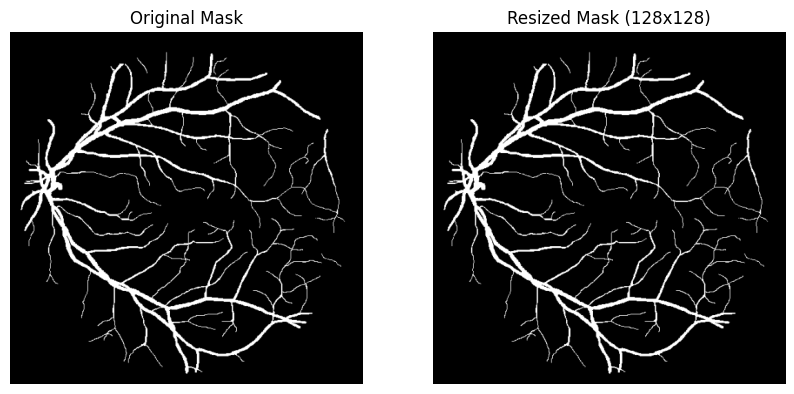

Visualizing sample 2:


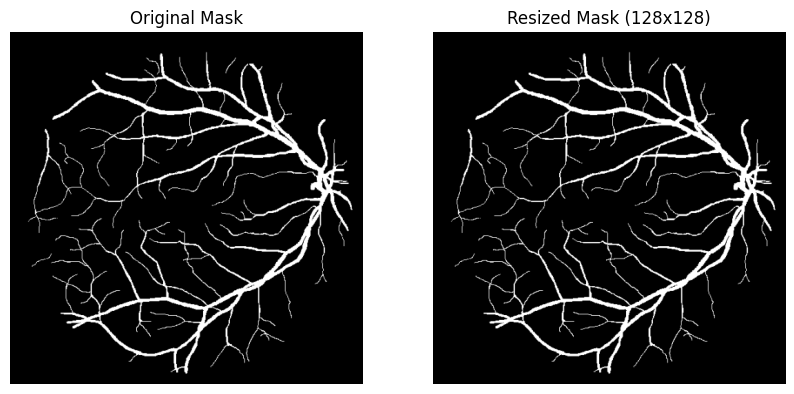

Visualizing sample 3:


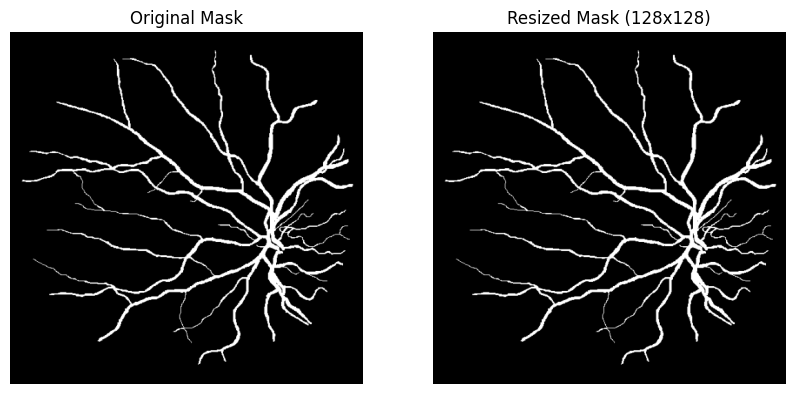

In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor

# Paths
image_path = "/content/retina-blood-vessel/Data/train/image"
mask_path = "/content/retina-blood-vessel/Data/train/mask"

# Output dimensions for the masks
mask_size = (512, 512)

# Image processor from transformers
image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Transform for resizing masks
resize_transform = transforms.Compose([
    transforms.Resize(mask_size),
    transforms.ToTensor()
])

class RetinaDataset(Dataset):
    """
    Custom Dataset for Retina Images and Segmentation Masks.
    """
    def __init__(self, image_dir, mask_dir, image_processor, mask_transform):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_processor = image_processor
        self.mask_transform = mask_transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Process the image and mask
        processed_img = self.image_processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)
        resized_mask = self.mask_transform(mask)

        return img, mask, processed_img, resized_mask

# Create dataset
dataset = RetinaDataset(
    image_dir=image_path,
    mask_dir=mask_path,
    image_processor=image_processor,
    mask_transform=resize_transform
)

# Visualize original and resized masks
def visualize_masks(idx, dataset):
    original_image, original_mask, _, resized_mask = dataset[idx]

    # Convert masks to numpy arrays for visualization
    original_mask = transforms.ToTensor()(original_mask).squeeze(0).numpy()
    resized_mask = resized_mask.squeeze(0).numpy()

    # Plot the original and resized masks
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_mask, cmap='gray')
    ax[0].set_title("Original Mask")
    ax[0].axis('off')
    ax[1].imshow(resized_mask, cmap='gray')
    ax[1].set_title("Resized Mask (128x128)")
    ax[1].axis('off')
    plt.show()

# Visualize a few samples
for i in range(3):  # Visualize the first 3 samples
    print(f"Visualizing sample {i + 1}:")
    visualize_masks(i, dataset)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor

# Paths
image_path = "/content/retina-blood-vessel/Data/train/image"
mask_path = "/content/retina-blood-vessel/Data/train/mask"

# Output dimensions for the masks
mask_size = (512, 512)

# Image processor from transformers
image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Transform for resizing masks
resize_transform = transforms.Compose([
    transforms.Resize(mask_size),
    transforms.ToTensor()
])

class RetinaDataset(Dataset):
    """
    Custom Dataset for Retina Images and Segmentation Masks.
    """
    def __init__(self, image_dir, mask_dir, image_processor, mask_transform):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_processor = image_processor
        self.mask_transform = mask_transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Process the image and mask
        processed_img = self.image_processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)
        processed_mask = self.mask_transform(mask)

        return processed_img, processed_mask

# Create dataset
dataset = RetinaDataset(
    image_dir=image_path,
    mask_dir=mask_path,
    image_processor=image_processor,
    mask_transform=resize_transform
)

# Create DataLoader
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example usage
for batch_idx, (images, masks) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print("Images Shape:", images.shape)
    print("Masks Shape:", masks.shape)
    break  # Display the first batch and exit


Batch 1:
Images Shape: torch.Size([4, 3, 512, 512])
Masks Shape: torch.Size([4, 1, 512, 512])


In [6]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
list(logits.shape)

[1, 150, 128, 128]

In [7]:
outputs.logits.shape

torch.Size([1, 150, 128, 128])

In [8]:
device="cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
for batch_idx, (images, masks) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print("Images Shape:", images.shape)
    print("Masks Shape:", masks.shape)
    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images)
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
    list(logits.shape)
    break

Batch 1:
Images Shape: torch.Size([4, 3, 512, 512])
Masks Shape: torch.Size([4, 1, 512, 512])


In [9]:
test_image_path = "/content/retina-blood-vessel/Data/test/image"
test_mask_path = "/content/retina-blood-vessel/Data/test/mask"
test_Data=RetinaDataset(
    image_dir=test_image_path,
    mask_dir=test_mask_path,
    image_processor=image_processor,
    mask_transform=resize_transform
)
test_dataloader = DataLoader(test_Data, batch_size=4, shuffle=True)

In [10]:
import torch
from transformers import SegformerForSemanticSegmentation

class SegmentationModel(torch.nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.backbone = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(150, 128, kernel_size=4, stride=2,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2,padding=1),)

        self.header = torch.nn.Sequential(
            torch.nn.Linear(64, 256),  # Adjusted from Segformer
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1)
        )

    def forward(self, x):
        # Pass input through Segformer backbone
        x = self.backbone(x)
        x = x.logits  # Extract the logits

        # Permute dimensions to (batch_size, height, width, channels)

        # Upsample to (512, 512)
        x = self.upsample(x)
        x = x.permute(0, 2, 3, 1)
        # Pass through header
        x = self.header(x)
        return x


In [11]:
from torch import nn
import torch.nn.functional as F
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE,dice_loss

In [12]:
seg_model=SegmentationModel()
seg_model.to(device)
criterion = DiceBCELoss()
optimizer = torch.optim.Adam(seg_model.parameters(), lr=0.001)

Epoch [1/100] - Train Loss: 0.9672, Eval Loss: 0.7888
New best model saved with Eval Loss: 0.7888
Epoch [2/100] - Train Loss: 0.7222, Eval Loss: 0.6130
New best model saved with Eval Loss: 0.6130
Epoch [3/100] - Train Loss: 0.6135, Eval Loss: 0.5301
New best model saved with Eval Loss: 0.5301
Epoch [4/100] - Train Loss: 0.5265, Eval Loss: 0.5162
New best model saved with Eval Loss: 0.5162
Epoch [5/100] - Train Loss: 0.4828, Eval Loss: 0.4461
New best model saved with Eval Loss: 0.4461
Epoch [6/100] - Train Loss: 0.4702, Eval Loss: 0.4614
Epoch [7/100] - Train Loss: 0.4465, Eval Loss: 0.4257
New best model saved with Eval Loss: 0.4257
Epoch [8/100] - Train Loss: 0.4318, Eval Loss: 0.4105
New best model saved with Eval Loss: 0.4105
Epoch [9/100] - Train Loss: 0.4173, Eval Loss: 0.4063
New best model saved with Eval Loss: 0.4063
Epoch [10/100] - Train Loss: 0.4124, Eval Loss: 0.4015
New best model saved with Eval Loss: 0.4015
Epoch [11/100] - Train Loss: 0.4045, Eval Loss: 0.3829
New best

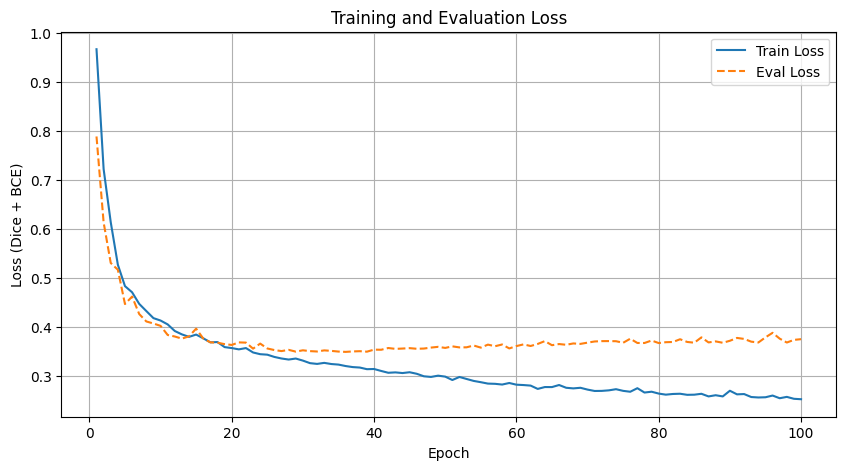

In [13]:
import torch
import matplotlib.pyplot as plt
import os

# Assuming you have:
# - seg_model: Your segmentation model
# - train_loader: DataLoader for training data
# - test_loader: DataLoader for testing data
# - criterion: Your loss function (Dice + BCE)
# - optimizer: Your optimizer
# - device: CUDA or CPU device

# Training and Evaluation
num_epochs = 100
train_losses = []
eval_losses = []
best_eval_loss = float('inf')  # Initialize to a very large value

# Directory to save the best model
save_dir = "/content/drive/MyDrive/AI_store/DeepLearning Projects/Retinal Segmantation"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    seg_model.train()
    train_loss = 0.0

    # Training loop
    for batch_idx, (images, masks) in enumerate(dataloader):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = seg_model(images)
        Dice_BCE, dice_loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        Dice_BCE.backward()
        optimizer.step()

        train_loss += Dice_BCE.item()

    # Average training loss for the epoch
    avg_train_loss = train_loss / len(dataloader)
    train_losses.append(avg_train_loss)

    # Evaluation loop
    seg_model.eval()
    eval_loss = 0.0
    with torch.no_grad():
        for images, masks in test_dataloader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = seg_model(images)
            Dice_BCE, dice_loss = criterion(outputs, masks)
            eval_loss += Dice_BCE.item()

    # Average evaluation loss for the epoch
    avg_eval_loss = eval_loss / len(test_dataloader)
    eval_losses.append(avg_eval_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}")

    # Save model if evaluation loss decreases
    if avg_eval_loss < best_eval_loss:
        best_eval_loss = avg_eval_loss
        model_path = os.path.join(save_dir, "segmodel_best.pt")
        torch.save(seg_model.state_dict(), model_path)
        print(f"New best model saved with Eval Loss: {best_eval_loss:.4f}")

# Plot Dice loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), eval_losses, label='Eval Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss (Dice + BCE)')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid()
plt.show()


In [15]:
import matplotlib.pyplot as plt

# Function to plot predictions and ground truth masks
def plot_predictions(model, test_loader, device, num_samples=3):
    """
    Plot a few test samples with ground truth and predictions.
    """
    model.eval()  # Set the model to evaluation mode
    samples_shown = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            # Get model predictions
            predictions = model(images)
            predictions = torch.sigmoid(predictions)  # Apply sigmoid for probabilities
            predictions = predictions > 0.5  # Threshold to create binary mask

            # Plot the samples
            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    break

                # Convert to CPU for visualization
                image = images[i].permute(1, 2, 0).cpu().numpy()
                ground_truth = masks[i].squeeze(0).cpu().numpy()
                prediction = predictions[i].squeeze(0).cpu().numpy()

                # Normalize the image to [0, 1] range (assuming image was normalized between 0 and 1)
                image = image - image.min()
                image = image / image.max()  # Now the image is between 0 and 1

                # Create subplots
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(image)
                axs[0].set_title("Input Image")
                axs[0].axis("off")

                axs[1].imshow(ground_truth, cmap="gray")
                axs[1].set_title("Ground Truth")
                axs[1].axis("off")

                axs[2].imshow(prediction, cmap="gray")
                axs[2].set_title("Prediction")
                axs[2].axis("off")

                plt.show()
                samples_shown += 1

            if samples_shown >= num_samples:
                break

# Plot predictions for 10 samples from the test loader
plot_predictions(seg_model, test_dataloader, device, num_samples=10)


Output hidden; open in https://colab.research.google.com to view.

In [30]:
import torch
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

class SegmentationInference:
    def __init__(self, model, device, output_dir="predictions"):
        """
        Initialize the inference class.
        :param model: The trained segmentation model.
        :param device: The device (cpu or cuda) on which the model is loaded.
        :param output_dir: Directory where predicted images will be saved.
        """
        self.model = model
        self.device = device
        self.model.to(device)
        self.model.eval()  # Set the model to evaluation mode

        # Ensure the output directory exists
        self.output_dir = output_dir
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        # Preprocessing transformations (adjust according to your model requirements)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Example normalization
        ])

    def predict(self, image_path):
        """
        Predict the segmentation mask for a given image path.
        :param image_path: Path to the input image.
        :return: Predicted mask (tensor).
        """
        # Load image
        image = Image.open(image_path).convert('RGB')  # Convert to RGB if it's a grayscale image
        image = image.resize((512, 512))  # Resize to 512x512 if needed for the model

        # Apply transformation to the image
        input_image = self.transform(image).unsqueeze(0).to(self.device)  # Add batch dimension and move to device

        # Make prediction
        with torch.no_grad():
            output = self.model(input_image)
            prediction = torch.sigmoid(output)  # Apply sigmoid for binary segmentation
            prediction = (prediction > 0.5).cpu().squeeze(0).numpy()  # Threshold and move to CPU for plotting

        return prediction, image

    def save_prediction(self, prediction, image_name):
        """
        Save the predicted mask as an image.
        :param prediction: The predicted binary mask.
        :param image_name: The name to save the predicted mask as.
        """
        prediction = prediction.squeeze()
        predicted_image = (prediction * 255).astype(np.uint8)
        predicted_image = Image.fromarray(predicted_image)  # Convert to PIL image

        # Save the image
        predicted_image.save(os.path.join(self.output_dir, f"{image_name}_prediction.png"))
        print(f"Prediction saved to: {os.path.join(self.output_dir, f'{image_name}_prediction.png')}")

    def plot_results(self, prediction, input_image, image_name):
        """
        Plot the input image, ground truth, and prediction, and save the prediction image.
        :param prediction: The predicted mask.
        :param input_image: The input image (PIL Image).
        :param image_name: The name of the input image.
        """
        # Convert input image to numpy array for plotting
        input_image = np.array(input_image)

        # Create subplots
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Plot input image
        axs[0].imshow(input_image)
        axs[0].set_title("Input Image")
        axs[0].axis("off")


        # Plot prediction
        axs[1].imshow(prediction, cmap="gray")
        axs[1].set_title("Prediction")
        axs[1].axis("off")

        # Save the predicted mask image
        self.save_prediction(prediction, image_name)

        plt.show()

In [18]:
model_path

'/content/drive/MyDrive/AI_store/DeepLearning Projects/Retinal Segmantation/segmodel_best.pt'

Prediction saved to: predictions/retinel segmantation_prediction.png


<ipython-input-31-2186ce6daa21>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


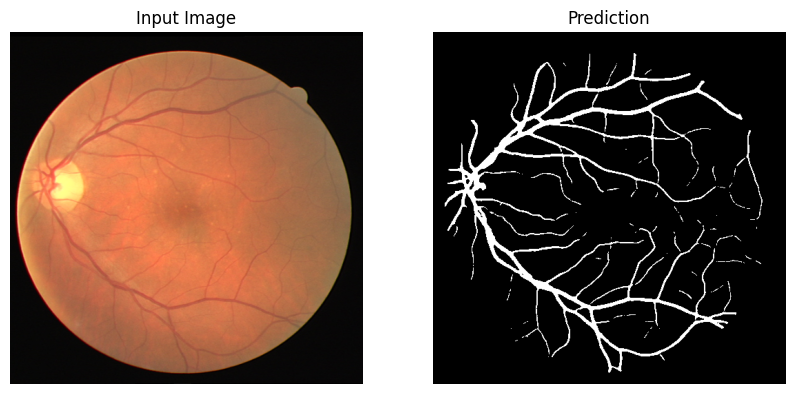

In [31]:
model = SegmentationModel()
#load
model.load_state_dict(torch.load(model_path))
inference = SegmentationInference(model, device)
image_path = "/content/drive/MyDrive/AI_store/DeepLearning Projects/Test Image/retinel segmantation.png"
prediction, input_image = inference.predict(image_path)
image_name = os.path.basename(image_path).split('.')[0]
    # Plot the results
inference.plot_results(prediction, input_image,image_name)